#### Librerias


In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pypfopt import EfficientFrontier, expected_returns
from pypfopt import risk_models
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import quantstats as qs

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### Funciones


###### _Log y Pct rends_


In [4]:
# funcion rendimientos log
def rlog(data):
    return np.log(data / data.shift(1)).dropna()

# Funcion rendimientos pct
def pct(data):
    return data.pct_change().dropna()

###### _Portafolio y metricas_


In [5]:
# Portafolio y metricas de preformance
"""def portafolio(data, nombre, risk_free = 0.05):
    # Calcular los rendimientos esperados y la matriz de covarianza
    mu = expected_returns.mean_historical_return(data)
    S = risk_models.sample_cov(data)
    
    # Crear el objeto EfficientFrontier
    ef = EfficientFrontier(mu, S)
    
    # Optimizar el portafolio para maximizar el ratio de Sharpe
    weights_sharpe = ef.max_sharpe(risk_free_rate=risk_free)
    cleaned_weights_sharpe = ef.clean_weights()
    performance_sharpe = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free)
    
    # Optimizar el portafolio para minimizar la volatilidad
    ef_min_vol = EfficientFrontier(mu, S)
    weights_min_vol = ef_min_vol.min_volatility()
    cleaned_weights_min_vol = ef_min_vol.clean_weights()
    performance_min_vol = ef_min_vol.portfolio_performance(verbose=True)
    
    # Optimizar el portafolio para maximizar el rendimiento
    ef_max_ret = EfficientFrontier(mu, S)
    weights_max_ret = ef_max_ret.max_quadratic_utility()
    cleaned_weights_max_ret = ef_max_ret.clean_weights()
    performance_max_ret = ef_max_ret.portfolio_performance(verbose=True)
    
    # Imprimir el nombre del portafolio
    print(f"Portafolio: {nombre}")
    
    # Retornar los pesos y rendimientos de los tres portafolios
    return {
        "max_sharpe": {
            "weights": cleaned_weights_sharpe,
            "performance": performance_sharpe
        },
        "min_volatility": {
            "weights": cleaned_weights_min_vol,
            "performance": performance_min_vol
        },
        "max_return": {
            "weights": cleaned_weights_max_ret,
            "performance": performance_max_ret
        },
        "nombre": nombre
    }
    """
def portafolio(data, nombre, risk_free=0.05):
    # Calcular los rendimientos esperados y la matriz de covarianza
    mu = expected_returns.mean_historical_return(data)
    S = risk_models.sample_cov(data)

    # Crear el objeto EfficientFrontier
    ef = EfficientFrontier(mu, S)

    # Optimizar el portafolio para maximizar el ratio de Sharpe
    weights_sharpe = ef.max_sharpe(risk_free_rate=risk_free)
    cleaned_weights_sharpe = ef.clean_weights()
    performance_sharpe = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free)

    # Optimizar el portafolio para minimizar la volatilidad
    ef_min_vol = EfficientFrontier(mu, S)
    weights_min_vol = ef_min_vol.min_volatility()
    cleaned_weights_min_vol = ef_min_vol.clean_weights()
    performance_min_vol = ef_min_vol.portfolio_performance(verbose=True)

    # Optimizar el portafolio para maximizar el rendimiento
    ef_max_ret = EfficientFrontier(mu, S)
    weights_max_ret = ef_max_ret.max_quadratic_utility()
    cleaned_weights_max_ret = ef_max_ret.clean_weights()
    performance_max_ret = ef_max_ret.portfolio_performance(verbose=True)

    # Imprimir el nombre del portafolio
    print(f"Portafolio: {nombre}")
    return (cleaned_weights_min_vol, cleaned_weights_sharpe, cleaned_weights_max_ret)

###### Frontera Eficiente

In [149]:
# Función para generar combinaciones aleatorias de portafolios
def weight_portfolios(activos, iteraciones=50000, min_weight=0.01):
    max_weight = 1 - (len(activos) * min_weight)
    portfolios = []
    for _ in range(iteraciones):
        weights = np.random.dirichlet(np.ones(len(activos)), size=1)[0]
        weights = np.clip(weights, min_weight, max_weight)
        portfolios.append(weights)
    portfolios = pd.DataFrame(portfolios, columns=activos)
    return portfolios

# Función para calcular y obtener métricas de portafolios específicos
def calcular_portafolios_especificos(data, risk_free=0.05):
    mu = expected_returns.mean_historical_return(data)
    S = risk_models.sample_cov(data)

    ef = EfficientFrontier(mu, S)

    # Portafolio de máximo Sharpe
    ef.max_sharpe(risk_free_rate=risk_free)
    weights_sharpe = ef.clean_weights()
    performance_sharpe = ef.portfolio_performance(risk_free_rate=risk_free)

    # Portafolio de mínima volatilidad
    ef_min_vol = EfficientFrontier(mu, S)
    ef_min_vol.min_volatility()
    weights_min_vol = ef_min_vol.clean_weights()
    performance_min_vol = ef_min_vol.portfolio_performance()

    # Portafolio de pesos iguales
    n_assets = len(mu)
    weights_equal = np.array([1/n_assets] * n_assets)
    ret_equal = np.dot(weights_equal, mu)
    vol_equal = np.sqrt(np.dot(weights_equal.T, np.dot(S, weights_equal)))
    sharpe_equal = (ret_equal - risk_free) / vol_equal
    performance_equal = (ret_equal, vol_equal, sharpe_equal)

    # Métricas de los activos individuales
    performance_activos = []
    for i, asset in enumerate(data.columns):
        weights_asset = np.zeros(n_assets)
        weights_asset[i] = 1
        ret_asset = np.dot(weights_asset, mu)
        vol_asset = np.sqrt(np.dot(weights_asset.T, np.dot(S, weights_asset)))
        sharpe_asset = (ret_asset - risk_free) / vol_asset
        performance_activos.append((asset, ret_asset, vol_asset, sharpe_asset))

    return {
        "sharpe": {"weights": weights_sharpe, "performance": performance_sharpe},
        "min_vol": {"weights": weights_min_vol, "performance": performance_min_vol},
        "equal": {"weights": weights_equal, "performance": performance_equal},
        "activos": performance_activos
    }

# Función para calcular las métricas de los portafolios generados aleatoriamente
def calcular_metricas_aleatorias(portfolios, mu, S, risk_free=0.05):
    expected_returns_all = portfolios.dot(mu)
    portfolio_volatility = np.sqrt(np.diag(portfolios.dot(S).dot(portfolios.T)))
    sharpe_ratios = (expected_returns_all - risk_free) / portfolio_volatility
    return expected_returns_all, portfolio_volatility, sharpe_ratios

# Función para graficar la frontera eficiente y los portafolios específicos
def graficar_frontera_eficiente(data, iteraciones=50000, risk_free=0.05):
    activos = data.columns.tolist()
    portfolios = weight_portfolios(activos, iteraciones)

    mu = expected_returns.mean_historical_return(data)
    S = risk_models.sample_cov(data)

    expected_returns_all, portfolio_volatility, sharpe_ratios = calcular_metricas_aleatorias(portfolios, mu, S, risk_free)

    # Calcular portafolios específicos
    portafolios_especificos = calcular_portafolios_especificos(data, risk_free)
    
    # Preparar datos para la gráfica
    rendimiento_sharpe = portafolios_especificos["sharpe"]["performance"][0]
    riesgo_sharpe = portafolios_especificos["sharpe"]["performance"][1]

    rendimiento_min_var = portafolios_especificos["min_vol"]["performance"][0]
    riesgo_min_var = portafolios_especificos["min_vol"]["performance"][1]

    rendimiento_igual = portafolios_especificos["equal"]["performance"][0]
    riesgo_igual = portafolios_especificos["equal"]["performance"][1]

    # Graficar
    plt.figure(figsize=(12, 8))
    plt.scatter(portfolio_volatility, expected_returns_all*100, c=-sharpe_ratios, cmap='viridis_r', alpha=0.7)
    plt.colorbar(label='Ratio de Sharpe', pad=0.1) 

    # Mejorar el estilo de la gráfica
    plt.xlabel('Volatilidad (Riesgo del Portafolio)', fontsize=12, fontweight='bold')
    plt.ylabel('Rendimiento Esperado del Portafolio % (anual)', fontsize=12, fontweight='bold')
    plt.title('Gráfica de Dispersión: Rendimiento vs. Volatilidad', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tick_params(axis='both', which='major', labelsize=10)

    # Añadir el punto del portafolio de mínima varianza en rojo
    plt.scatter(riesgo_min_var, rendimiento_min_var*100, color='#FF4500', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Mínima Varianza')

    # Añadir el punto del portafolio de pesos iguales en morado
    plt.scatter(riesgo_igual, rendimiento_igual*100, color='#9370DB', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio Equal Weight')

    # Añadir el punto del portafolio de máximo Sharpe en azul
    plt.scatter(riesgo_sharpe, rendimiento_sharpe*100, color='#1E90FF', s=150, marker='*', edgecolors='#1A1A1A', linewidth=0.8, label='Portafolio de Máximo Sharpe')

    # Añadir los puntos de los activos individuales con etiquetas en la gráfica
    for (asset, ret_asset, vol_asset, sharpe_asset) in portafolios_especificos["activos"]:
        plt.scatter(vol_asset, ret_asset*100, marker='o', s=35, edgecolors='black', facecolors='none')
        plt.text(vol_asset, (ret_asset*100)-3, asset, fontsize=8, fontweight='bold', ha='center', color='#0A0A0A')

    plt.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0.01, 0.99)) 
    plt.text(0.4, 0.96, f'Tasa libre de riesgo: {risk_free*100:.2f}%', transform=plt.gca().transAxes, fontsize=10, color='#363636')
    plt.show()

###### _Drawdown y Rendimientos acumulados_


In [58]:
#! NO FUNCIONA

# Función para calcular el drawdown
def calcular_drawdown(data):
    cum_returns = (1 + data).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown

# Función para graficar el rendimiento acumulado, drawdown y underwater
def graficar_rendimiento_drawdown(data, nombre):
    rendimientos = pct(data).dropna()
    drawdown = calcular_drawdown(rendimientos)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    # Graficar el rendimiento acumulado
    (1 + rendimientos).cumprod().plot(ax=ax1)
    ax1.set_title(f'Rendimiento Acumulado del Portafolio: {nombre}')
    ax1.set_ylabel('Rendimiento Acumulado')
    
    # Graficar el drawdown
    drawdown.plot(ax=ax2)
    ax2.set_title('Drawdown del Portafolio')
    ax2.set_ylabel('Drawdown')
    
    # Graficar el underwater
    drawdown.plot(ax=ax3, color='blue')
    ax3.fill_between(drawdown.index, drawdown, alpha=0.3)
    ax3.set_title('Underwater del Portafolio')
    ax3.set_ylabel('Drawdown')
    ax3.set_xlabel('Fecha')
    
    plt.tight_layout()
    plt.show()

In [17]:

def weight_portfolios(activos, iteraciones=50000,min_weight=0.01):
    # Genera iteraciones random de combinaciones de portafolios
    max_weight=1-(len(activos)*min_weight)
    portfolios = []
    for _ in range(iteraciones):
        weights = np.random.dirichlet(np.ones(len(activos)), size=1)[0]
        weights = np.clip(weights, min_weight, max_weight)
        portfolios.append(weights)

    # Convierte las combinaciones a un DataFrame
    portfolios = pd.DataFrame(portfolios, columns=activos)
    return portfolios
# Funcion para Graficar frontera eficiente con portafolios de solo 1 activo, maximo ratio sharpe, min riesgo y pesos iguales


###### _Portafolio de riesgo fijo_


In [11]:
# Función para calcular el portafolio optimizado con un riesgo máximo específico
def portafolio_con_riesgo_fijo(data, nombre, riesgo_maximo):
    # Calcular los rendimientos esperados y la matriz de covarianza
    mu = expected_returns.mean_historical_return(data)
    S = risk_models.sample_cov(data)
    
    # Crear el objeto EfficientFrontier
    ef = EfficientFrontier(mu, S)
    
    # Optimizar el portafolio para limitar el riesgo a un número específico máximo
    weights_risk_limited = ef.efficient_risk(riesgo_maximo)
    cleaned_weights_risk_limited = ef.clean_weights()
    performance_risk_limited = ef.portfolio_performance(verbose=True)
    
    # Imprimir el nombre del portafolio
    print(f"Portafolio: {nombre}")
    
    # Retornar los pesos y rendimientos del portafolio optimizado con riesgo limitado
    return {
        "risk_limited": {
            "weights": cleaned_weights_risk_limited,
            "performance": performance_risk_limited
        },
        "nombre": nombre
    }

###### _Meticas clave_


In [112]:
# Obtener key metrics de los portafolios con quantstats
def key_metrics(data, risk_free=0.05):
    rendimientos = pct(data).dropna()
    qs.reports.html(rendimientos, output='report.html', rf=risk_free)
    return qs.reports.metrics(rendimientos, mode='full', rf=risk_free)

#### Data


In [7]:
# Fecha de inicio
start = '2015-01-01'

In [53]:
# Obtener datos de criptomonedas 
tk_cry = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'TRX-USD', 'XRP-USD']
cripto = yf.download(tk_cry, start=start)['Adj Close']
cripto.columns = ['BTC', 'ETH', 'SOL', 'TRX', 'XRP']
cripto.dropna(inplace=True)
cripto.head()

[*********************100%%**********************]  5 of 5 completed


,BTC,ETH,SOL,TRX,XRP
Date,,,,,
2020-04-10,6865.493164,158.412445,0.951054,0.012462,0.187464
2020-04-11,6859.083008,158.216019,0.776819,0.012483,0.188063
2020-04-12,6971.091797,161.142426,0.882507,0.012902,0.190135
2020-04-13,6845.037598,156.279556,0.777832,0.012585,0.187732
2020-04-14,6842.427734,157.596390,0.661925,0.012413,0.185335


<Axes: xlabel='Date'>

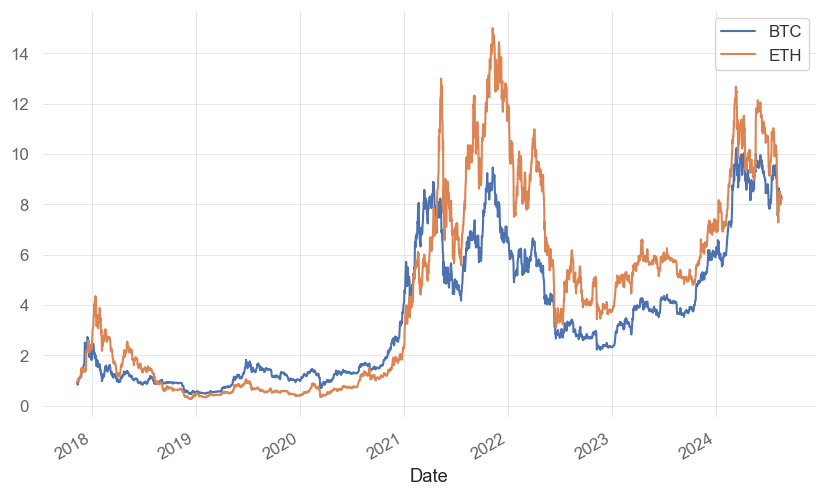

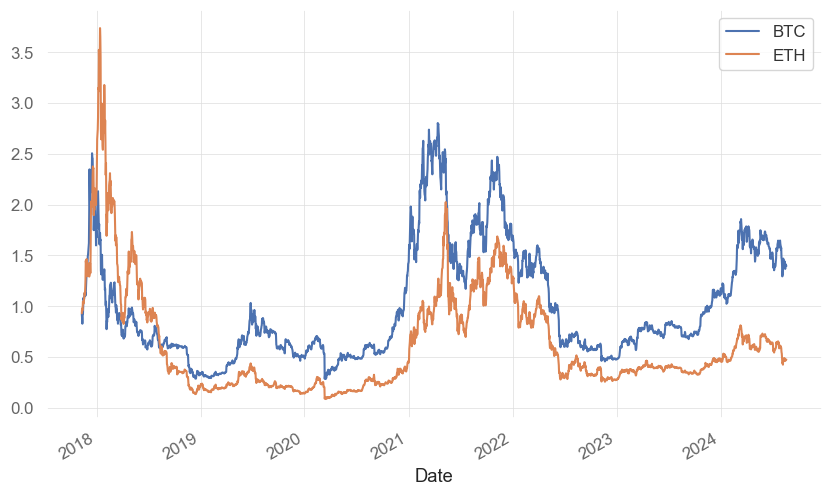

In [52]:
# Grafica con rendimientos acumulados
(1 + pct(cripto)).cumprod().plot(figsize=(10, 6))
(1+ rlog(cripto)).cumprod().plot(figsize=(10, 6))

In [14]:
# Obtener datos de ETF mercados emergentes
tk_emerg_etf = ['EEM', 'VWO']
emerg_etf = yf.download(tk_emerg_etf, start=start)['Adj Close']
emerg_etf.columns = ['EEM', 'VWO']
emerg_etf.head()

[*********************100%%**********************]  2 of 2 completed


,EEM,VWO
Date,,
2015-01-02,31.612553,30.274818
2015-01-05,31.049940,29.792686
2015-01-06,30.919477,29.647285
2015-01-07,31.588099,30.328398
2015-01-08,32.126247,30.841133


In [ ]:
# Obtener datos de principales indices del mundo
tk_major_ind = ['^GSPC', '^IXIC', '^GDAXI', '^FTSE', '^N225']
major_ind = yf.download(tk_major_ind, start=start)['Adj Close']
major_ind.columns = ['SP500', 'NASDAQ', 'DAX', 'FTSE', 'NIKKEI']
major_ind.head()

In [ ]:
# Datos de indices principales de Mexico, brasil, china, india, rusia, turquia, colombia, argentina, taiwan, corea del sur, sudafrica, indonesia, tailandia, malasia, filipinas, polonia, hungria, chile, peru, egipto
tk_emerging_markets = ['^MXX', '^BVSP', '000001.SS', '^BSESN', '^N225', '^ATG', '^MERV', '^TWII', '^KS11', '^JN0U.FGI', '^FTSEJSE', '^JKSE', '^SET.BK', '^KLSE', '^PSEI', '^WIG', '^BUX', '^IPSA', '^SPBLPGPT', '^EGX30']
emerging_markets = yf.download(tk_emerging_markets, start=start)['Adj Close']
emerging_markets.columns = ['MEX', 'BRA', 'CHN', 'IND', 'RUS', 'TUR', 'COL', 'ARG', 'TWN', 'KOR', 'ZAF', 'IDN', 'THA', 'MYS', 'PHL', 'POL', 'HUN', 'CHL', 'PER', 'EGY']
emerging_markets.head()

In [ ]:
# Datos de materias, oro, petroleo
tk_commodities = ['GC=F', 'CL=F']
commodities = yf.download(tk_commodities, start=start)['Adj Close']
commodities.columns = ['Gold', 'Oil']
commodities.head()

In [ ]:
# Datos de divisas
tk_fx = ['EURUSD=X', 'JPY=X', 'GBPUSD=X']
fx = yf.download(tk_fx, start=start)['Adj Close']
fx.columns = ['EURUSD', 'JPY', 'GBPUSD']
fx.head()

#### Analisis


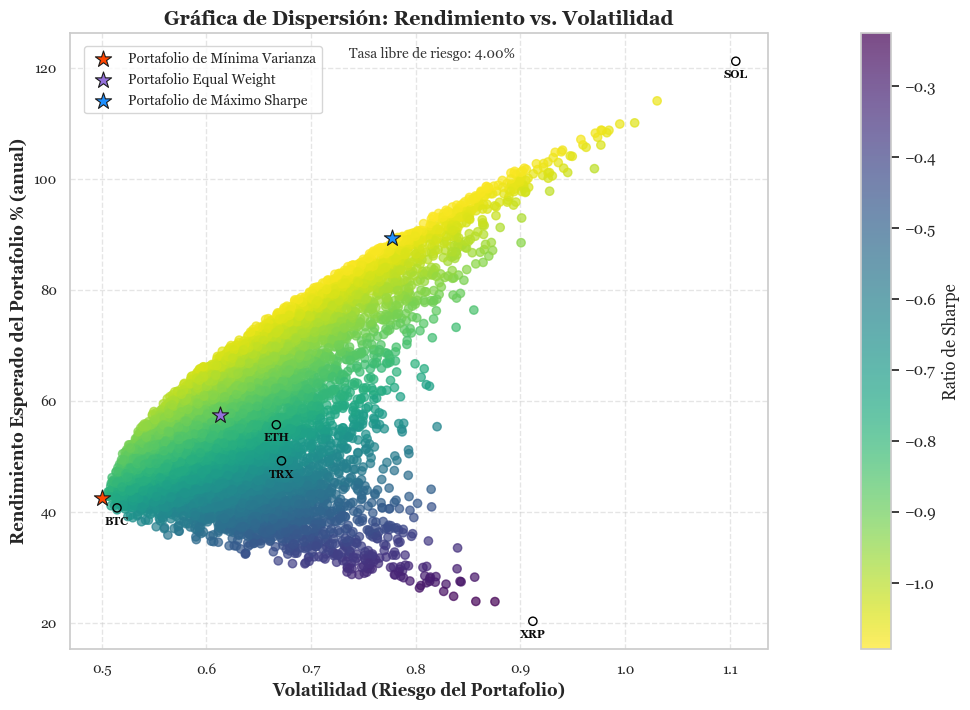

In [148]:
graficar_frontera_eficiente(cripto, iteraciones=10000, risk_free=0.04)

In [114]:
metricas_etf_emergentes = key_metrics(cripto, risk_free=0.04)
print(metricas_etf_emergentes)

                           BTC         ETH         SOL         TRX         XRP
-------------------------  ----------  ----------  ----------  ----------  ----------
Start Period               2020-04-11  2020-04-11  2020-04-11  2020-04-11  2020-04-11
End Period                 2024-08-20  2024-08-20  2024-08-20  2024-08-20  2024-08-20
Risk-Free Rate             4.0%        4.0%        4.0%        4.0%        4.0%
Time in Market             100.0%      100.0%      100.0%      100.0%      100.0%

Cumulative Return          764.93%     1,539.70%   15,005.86%  1,152.30%   220.76%
CAGR﹪                     40.71%      55.7%       121.28%     49.2%       20.26%

Sharpe                     0.84        0.94        1.23        0.87        0.59
Prob. Sharpe Ratio         76.4%       81.93%      94.66%      77.29%      49.49%
Smart Sharpe               0.82        0.91        1.19        0.84        0.57
Sortino                    1.26        1.41        1.99        1.33        1.0
Smart Sortino 